# Linear Regression:

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Sampling Bias:
Before we begin, we are going to talk about sampling bias. It is important to be awere about this question,and also others causal factors, to understanting the Linear regression parameters. 

If you want to just predict, this tutorial is not for you, maybe you also want to use another statistical model.  

If you want to deep undertanding Linear regression, let's go. 

The sampling bias is samething that is present in every database. It can be really dangerous for the model interpretation, or not. 

Here is a toy example about what I am talking about.

Text(0, 0.5, 'x2')

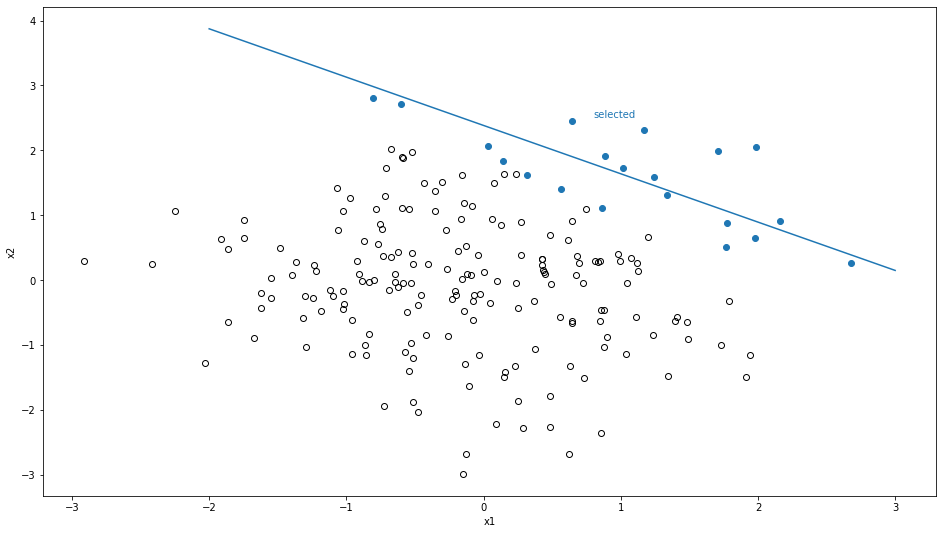

In [2]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("x1")
plt.ylabel("x2")

### Example of Linear regression:

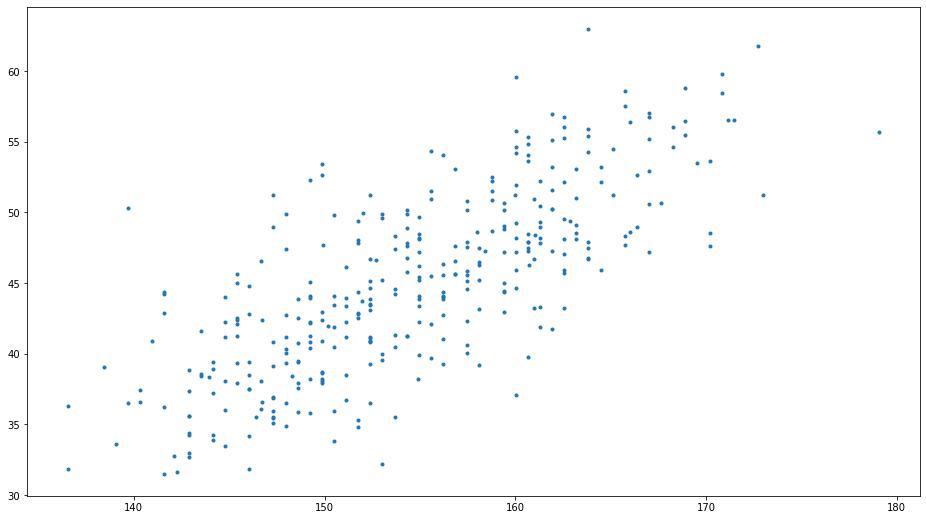

In [3]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
data = d[d.age > 18]
plt.plot(data.height, data.weight, ".");

### Defining the priors: 
Now, we are going to define the distribution prior of the models parameters. 
To heck if we defined a good prior, we are going to sample from it and se the sintetical predictions. 

Those predictions are based on sintetical input in the range of values from the true data. 

Two prior were analysed. Both of than uses the same intercept distribution and analyst tw variation of the trand. the firs is a nomal prior and the second is a Log normal prior. 

In [4]:
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

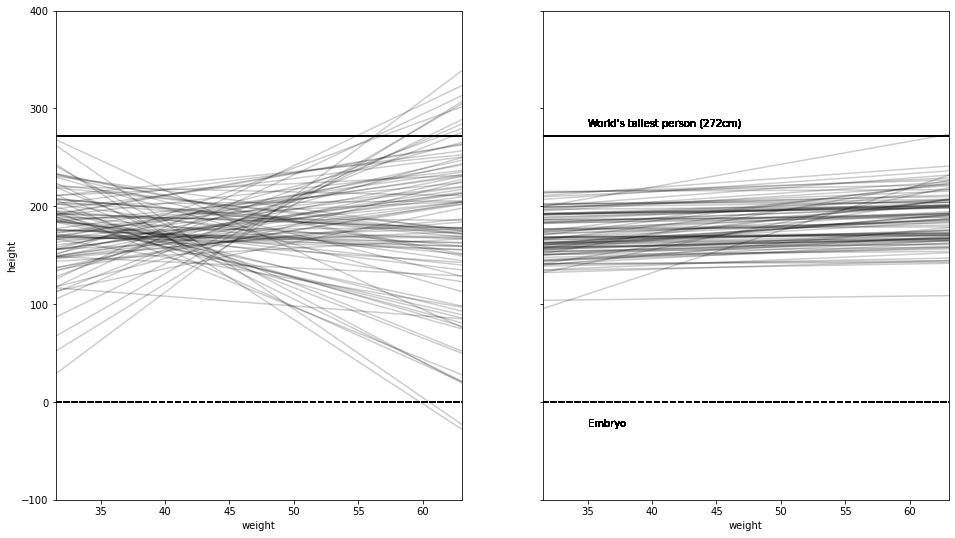

In [5]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = data.weight.mean()
x = np.linspace(data.weight.min(), data.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(data.weight.min(), data.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=N)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(data.weight.min(), data.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

Notice that just make sense the Log normal because the trend must be positive. 

In [6]:
with pm.Model() as lr_1:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (data.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=data.height)
    trace_lr_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 587 seconds.


In [7]:
az.summary(trace_lr_1, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
a,154.655,0.279,154.153,155.195
b,0.905,0.044,0.821,0.983
sigma,5.141,0.205,4.780,5.545


In [8]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Normal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (data.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=data.height)
    trace_lr_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 521 seconds.


In [21]:
lr_2_df = pd.DataFrame([])
lr_2_df['a'] = trace_lr_2['a']
lr_2_df['b'] =np.exp(trace_lr_2['b'])
lr_2_df.describe().drop(index = 'count').transpose()

,mean,std,min,25%,50%,75%,max
a,154.652617,0.288498,153.458791,154.457258,154.641338,154.846125,155.900903
b,0.904219,0.043956,0.745732,0.875166,0.903744,0.934545,1.057467


Notice that we use two differents prior of the parameters, The results are nearly the same!!! 

After that, it is important to analise the correlaion between parameters

In [22]:
trace_df_1 = pm.trace_to_dataframe(trace_lr_1)
trace_df_1.cov().round(3)

,a,b,sigma
a,0.078,0.000,0.001
b,0.000,0.002,0.000
sigma,0.001,0.000,0.042


In [23]:
trace_df_2 = pm.trace_to_dataframe(trace_lr_2)
trace_df_2.cov().round(3)

,a,b,sigma
a,0.083,0.000,0.002
b,0.000,0.002,-0.000
sigma,0.002,-0.000,0.042


Now we are going to see the prediction ussing the mean of the posterior of each parameter. 

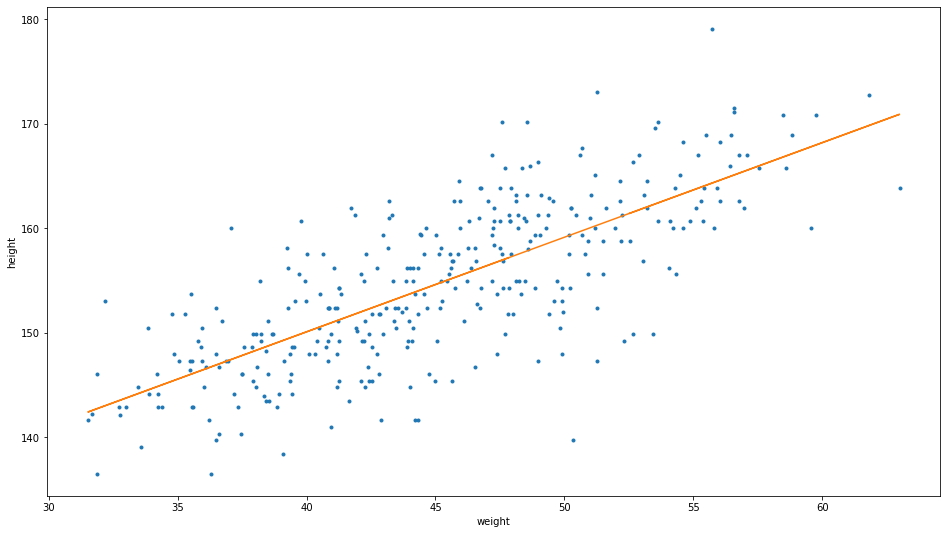

In [23]:
plt.plot(data.weight, data.height, ".")
plt.plot(data.weight, trace_lr_1["a"].mean() + trace_lr_1["b"].mean() * (data.weight - xbar))
plt.xlabel(data.columns[1])
plt.ylabel(data.columns[0]);

 Fitting the model with tiny data, and define a wider priors. 

In [24]:
N = [10, 50, 150, 352][0]
dN = data[:N]
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (dN.weight - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=dN.height)
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


We are going to sample some values from the posterior distribution of the parameters.

Note that we unifomly sample the parameters. So, we do not care about which is the probability of each of them. 

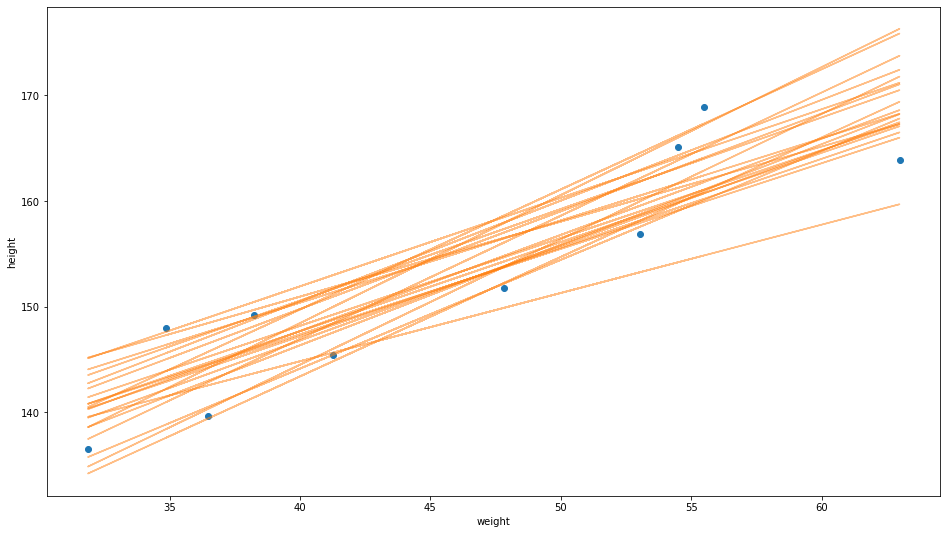

In [25]:
plt.plot(dN.weight, dN.height, "C0o")
idxs = np.random.randint(len(trace_N), size=20)
for idx in idxs:
    plt.plot(
        dN.weight,
        trace_N["a"][idx] + trace_N["b"][idx] * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(data.columns[1])
plt.ylabel(data.columns[0]);

Notice how flexible are the model. The plot above jus get aleatory samples of the posterior distribution of the parameters and use it to draw the line. 



Now, we are going to analyse a interesting thing. We are going to analyse the outcome of an especific point. Remember, in linear Regression, we are predictiong the outcome of each point as a Normal probability distribution

So, it is not just the mean, it is a hole distribution. 

We are going to predict the height distribution of a person with 50Kg.

This is the posterior predictive distribution

None the trace_lr_1["a"] variable is a sample of size 4000 from the posterior. 

In [44]:
mu_at_50 = trace_lr_1["a"] + trace_lr_1["b"] * (50 - data.weight.mean())

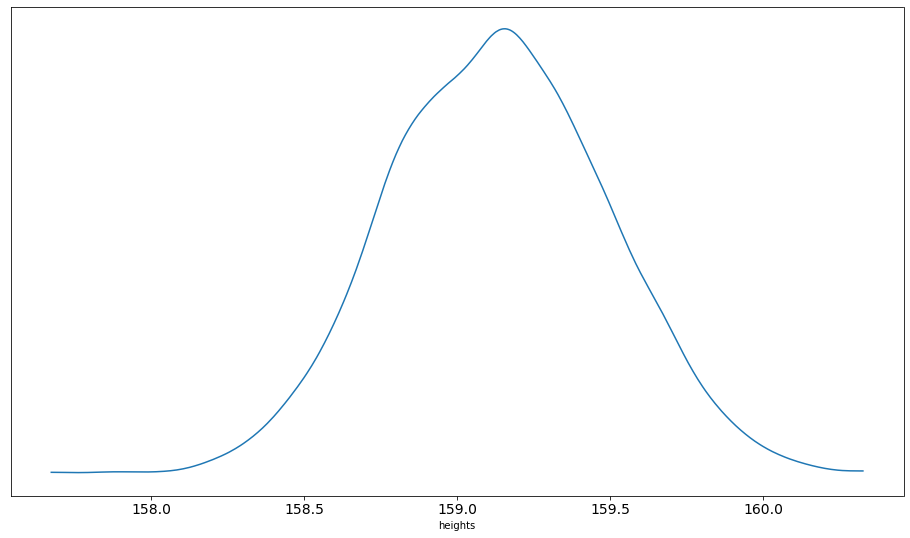

In [43]:
az.plot_kde(mu_at_50)
plt.xlabel("heights")
plt.yticks([]);

Now, make this calculation for every point. 

we are going to define some sitetical Weight points and calculate the height points distribution of each one. 

In [32]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_4_3_thinned = trace_lr_1[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_4_3_thinned) * trace_lr_1.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - data.weight.mean())

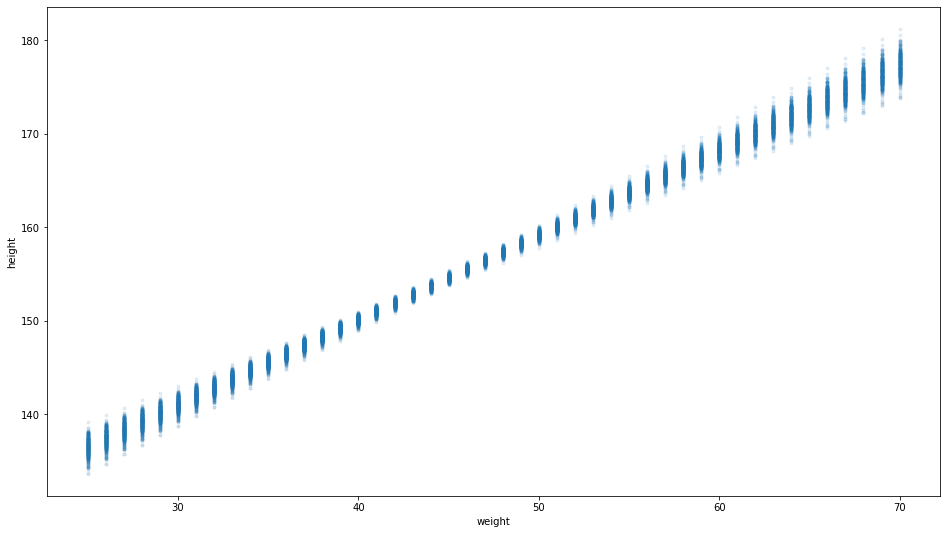

In [33]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

So, thet is the real outcome of an Linear regression. We can see the uncertain of the predictions changing acording to the value. 

Now let's plot the true data together with Line prediction. 

Notice that the uncertain increases in the border due to the lack of points.

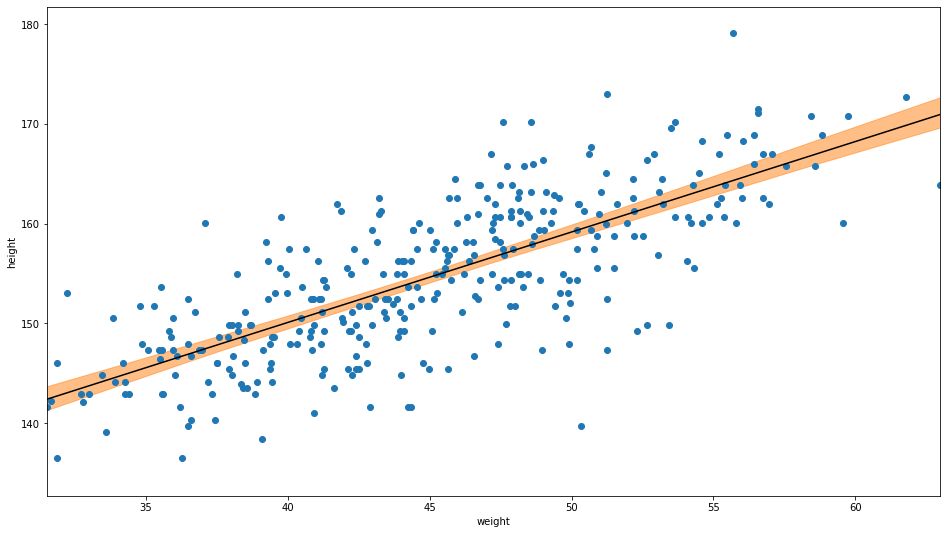

In [34]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(data.weight, data.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data.weight.min(), data.weight.max());

Now we are going to use sample_posterior_predictive() from PyCM3, intead of doing it manually. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height'].shape is (200, 352)

In [35]:
height_pred = pm.sample_posterior_predictive(trace_lr_1, 200, lr_1)

C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\pymc3\sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [36]:
height_pred['height'].shape

(200, 346)

In [37]:
height_pred_hdi = az.hdi(height_pred["height"])

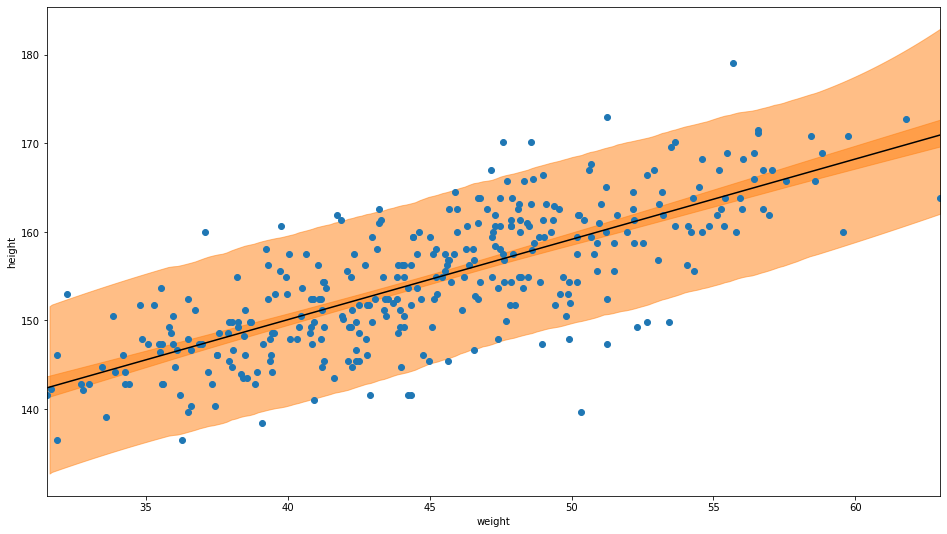

In [38]:
#the heights means of the predictive distribution.(sintetic points)
ax = az.plot_hdi(weight_seq, mu_pred.T)

#the heights means of the predictive distribution.(all true points)
az.plot_hdi(data.weight, height_pred["height"], ax=ax)
plt.scatter(data.weight, data.height)

#This is the line of the sintetic weight and the mean of the posterior predict heights of each points
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data.weight.min(), data.weight.max());

## Linear regression of higher orders:

Now we are going to model this problem as a segond order linear regression.

In [39]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

with pm.Model() as m_lr_2:
    a = pm.Normal("a", mu=178, sd=100)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d.weight_std + b2 * d.weight_std2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_lr_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1644 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


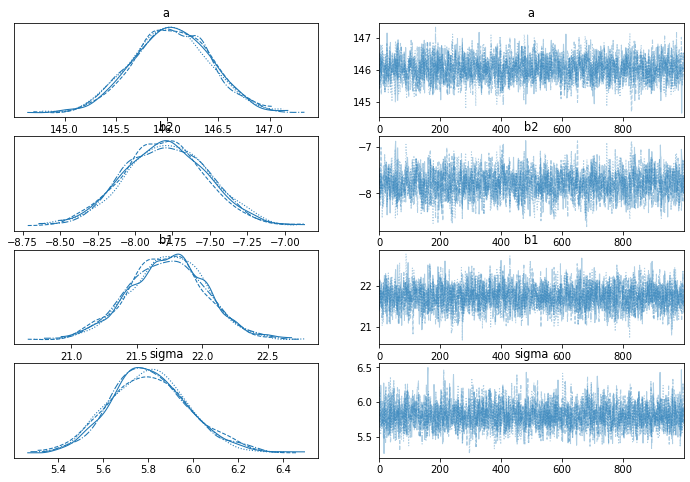

In [40]:
varnames = ["~mu"]
az.plot_trace(trace_lr_2, varnames);

In [41]:
az.summary(trace_lr_2, varnames, kind="stats", round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%
a,146.04,0.38,145.34,146.75
b2,-7.79,0.28,-8.31,-7.25
b1,21.73,0.29,21.18,22.28
sigma,5.81,0.18,5.50,6.16


In [43]:
mu_pred = trace_lr_2["mu"]
height_pred = pm.sample_posterior_predictive(trace_lr_2, 200, m_lr_2)

C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\pymc3\sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


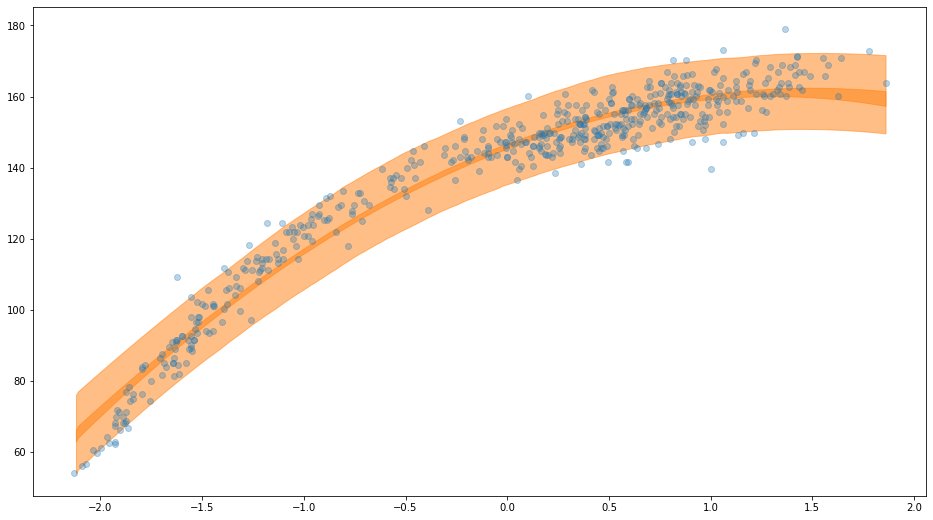

In [44]:
ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

Now, use a third order Linear Regression.

In [45]:
weight_m = np.vstack((d.weight_std, d.weight_std ** 2, d.weight_std ** 3))
with pm.Model() as m_lr_3:
    a = pm.Normal("a", mu=178, sd=100)
    b = pm.Normal("b", mu=0, sd=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    trace_lr_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1011 seconds.
The acceptance probability does not match the target. It is 0.8887880147597743, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\gcram\miniconda3\envs\torch_v2\lib\site-packages\pymc3\sampling.py:1709: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


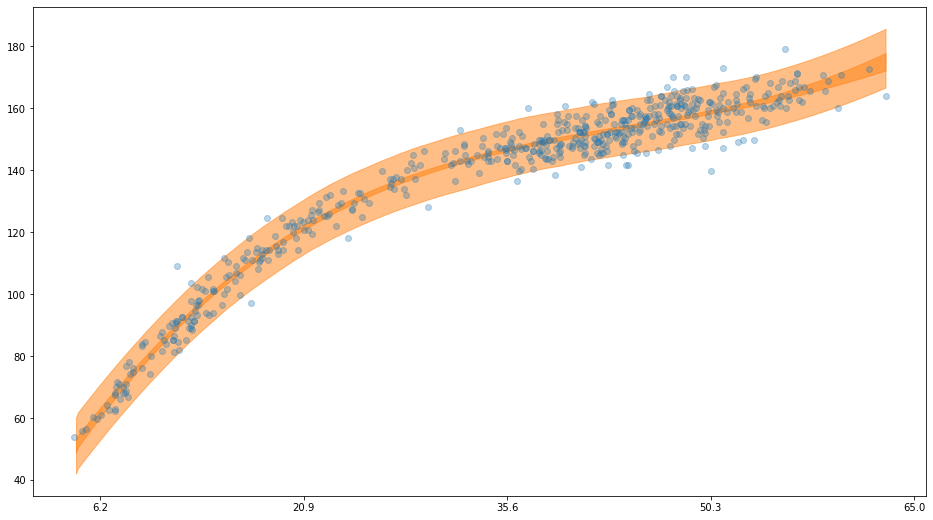

In [47]:
mu_pred = trace_lr_3["mu"]
height_pred = pm.sample_posterior_predictive(trace_lr_3, 200, m_lr_3)

ax = az.plot_hdi(d.weight_std, mu_pred)
az.plot_hdi(d.weight_std, height_pred["height"], ax=ax)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));